In [1]:
!pip install qiskit qiskit-aer torch torchvision matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 70.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 100.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 101.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2

In [5]:
# ライブラリの読み込み
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch import optim

import numpy as np
import matplotlib.pyplot as plt
import os
import time

# Qiskit
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer

In [6]:
# --- 量子サンプル生成 ---
def generate_quantum_samples(num_qubits, num_samples):
    qc = QuantumCircuit(num_qubits, num_qubits)
    for q in range(num_qubits):
        qc.h(q)
    qc.measure(range(num_qubits), range(num_qubits))

    backend = Aer.get_backend('aer_simulator')
    tqc = transpile(qc, backend)
    job = backend.run(tqc, shots=num_samples)
    result = job.result()
    counts = result.get_counts()

    samples = []
    for bitstring, count in counts.items():
        arr = [2 * int(b) - 1 for b in reversed(bitstring)]
        samples.extend([arr] * count)

    samples = samples[:num_samples]
    return torch.tensor(samples, dtype=torch.float32)


# --- VAEモデル定義 ---
class VAE(nn.Module):
    def __init__(self, z_dim, device='cuda'):
        super().__init__()
        self.device = device
        self.z_dim = z_dim

        self.enc_mean = nn.Linear(200, z_dim)
        self.enc_var = nn.Linear(200, z_dim)

        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 200),
            nn.ReLU(),
            nn.Linear(200, 200),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.Linear(z_dim, 200),
            nn.ReLU(),
            nn.Linear(200, 200),
            nn.ReLU(),
            nn.Linear(200, 28 * 28),
            nn.Sigmoid()
        )

    def _encoder(self, x):
        h = self.encoder(x)
        mean = self.enc_mean(h)
        var = F.softplus(self.enc_var(h))
        return mean, var

    def _sample_z(self, mean, var):
        batch_size = mean.shape[0]
        quantum_eps = generate_quantum_samples(self.z_dim, batch_size).to(self.device)
        return mean + torch.sqrt(var) * quantum_eps

    def _decoder(self, z):
        return self.decoder(z)

    def forward(self, x):
        mean, var = self._encoder(x)
        z = self._sample_z(mean, var)
        y = self._decoder(z)
        return y, z

    def loss(self, x):
        mean, var = self._encoder(x)
        KL = -0.5 * torch.mean(torch.sum(1 + torch.log(var) - mean**2 - var, dim=1))
        z = self._sample_z(mean, var)
        y = self._decoder(z)
        reconstruction = torch.mean(
            torch.sum(
                x * torch.log(y + 1e-8) + (1 - x) * torch.log(1 - y + 1e-8),
                dim=1
            )
        )
        lower_bound = reconstruction - KL
        return lower_bound


In [8]:
# ディレクトリの設定
DATAROOT = 'mnist'
os.makedirs(DATAROOT, exist_ok=True)

# 画像サイズ
image_size = 28

# バッチサイズ
batch_size = 512

# 前処理の内容を設定
dset_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        # 1次元に平滑化(1, 28, 28 -> 784)
        transforms.Lambda(lambda x: x.view(-1))
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        # 1次元に変更(1, 28, 28 -> 784)
        transforms.Lambda(lambda x: x.view(-1))
    ]),
}

# MNISTデータセットをダウンロードして加工
# 学習データ
train_dataset = dset.MNIST(root=DATAROOT,
                           train=True,
                           download=True,
                           transform=dset_transforms['train'])
# 学習データ用のデータローダ
train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True)

# テストデータ
test_dataset = dset.MNIST(root=DATAROOT,
                           train=False,
                           download=True,
                           transform=dset_transforms['test'])
# テストデータ用のデータローダ
test_loader = DataLoader(test_dataset,
                         batch_size=batch_size,
                         shuffle=False)


In [10]:
# --- 学習設定 ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 10
model = VAE(latent_dim, device).to(device)
criterion = model.loss
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 20
train_loss_list = []

In [11]:
%%time

# --- 学習ループ ---
for epoch in range(epochs):
    batch_loss_list = []
    model.train()
    start_time = time.time()

    for x, _ in train_loader:
        x = x.view(-1, 28 * 28).to(device)
        loss = -1 * criterion(x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_loss_list.append(loss.item())

    epoch_time = time.time() - start_time
    train_loss_list.append(np.mean(batch_loss_list))

    if epoch % 5 == 0:
        print(f'Epoch {epoch + 1:02d}, Loss: {train_loss_list[-1]:.4f}, Time: {epoch_time:.2f}s')

Epoch 01, Loss: 234.0447, Time: 36.37s
Epoch 06, Loss: 133.0138, Time: 34.12s
Epoch 11, Loss: 121.3902, Time: 33.84s
Epoch 16, Loss: 116.0579, Time: 34.26s
CPU times: user 11min 36s, sys: 5.1 s, total: 11min 41s
Wall time: 11min 34s


112.09472539869405


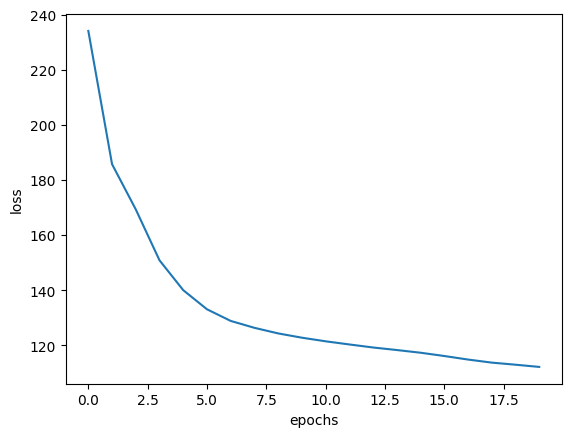

In [12]:
# 訓練損失の表示
print(train_loss_list[-1])
plt.plot(train_loss_list)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

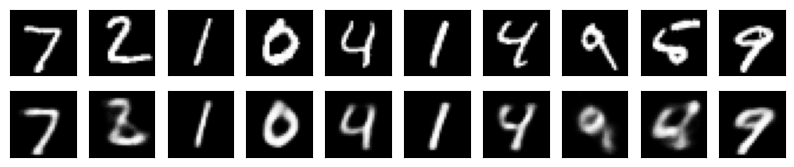

In [14]:
# キャンバスサイズの設定
fig = plt.figure(figsize=(10, 3))

# テストデータの読み込み
x, t = next(iter(test_loader))
# 元画像を表示
for i, im in enumerate(x.view(-1, 28, 28).detach().clone().numpy()[:10]):
    ax = fig.add_subplot(3, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(im, 'gray')

# モデルをCPU/GPUモードに変更
model.to(device)
# モデルを推論モードに変更
model.eval()

# 再構成画像と潜在変数を出力
y, z = model(x.to(device))
y = y.view(-1, 28, 28)

# 画像を並べて表示
for i, im in enumerate(y.cpu().detach().clone().numpy()[:10]):
    ax = fig.add_subplot(3, 10, i + 11, xticks=[], yticks=[])
    ax.imshow(im, 'gray')